In [ ]:
# 사용하는 라이브러리 다 불러오기
import pandas as pd
from geopy.geocoders import Nominatim
import re
import numpy as np
import matplotlib.pyplot as plt
import folium


# matplotlib에서 한글 깨짐 문제 발생
# 한글 폰트 사용을 위해서 폰트 설치
# 참고 - https://www.whatwant.com/entry/matplotlib-hangul-colab-local
# 실행 후 런타임 다시 시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


#설치한 폰트 사용
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd

#데이터 불러오기
original_data = pd.read_csv("data.csv", encoding='cp949')
data = original_data

### 1. 데이터 확인

In [ ]:
data.head()

,도서관명,시도명,시군구명,도서관유형,휴관일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,공휴일운영시작시각,...,운영기관명,도서관전화번호,부지면적,건물면적,홈페이지주소,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,이석영뉴미디어도서관,경기도,남양주시,공공도서관,둘째·넷째 금요일+1월 1일+설날·추석 연휴(대체공휴일 포함),9:00,22:00,9:00,18:00,9:00,...,사단법인 문화현상,031-595-8390,1843.0,4877.0,http://lib.nyj.go.kr/lsy,37.658160,127.299532,2023-04-30,3990000,경기도 남양주시
1,원덕도서관,강원도,삼척시,공공도서관,토요일+일요일+법정공휴일,9:00,18:00,0:00,0:00,0:00,...,강원도 삼척시청,033-572-4819,766.0,364.0,NaN,37.176854,129.335484,2023-06-20,4241000,강원특별자치도 삼척시
2,가평군 한석봉도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,7:00,...,경기도 가평군,031-580-4041,7485.0,3602.0,www.gaplib.go.kr,37.829691,127.506433,2023-06-21,4160000,경기도 가평군
3,가평군 설악도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,7:00,...,경기도 가평군,031-580-4313,3693.0,1470.0,www.gaplib.go.kr,37.683315,127.491015,2023-06-21,4160000,경기도 가평군
4,가평군 청평도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,7:00,...,경기도 가평군,031-580-4332,4500.0,2486.0,www.gaplib.go.kr,37.739591,127.424230,2023-06-21,4160000,경기도 가평군


In [ ]:
#NaN값 확인 - 위도, 경도가 없는 경우가 많음 -> 소재지 도로명 주소는 있음
data.isnull().sum()

도서관명             0
시도명              0
시군구명             0
도서관유형            0
휴관일              0
평일운영시작시각         0
평일운영종료시각         0
토요일운영시작시각        0
토요일운영종료시각        0
공휴일운영시작시각        0
공휴일운영종료시각        0
열람좌석수            0
자료수(도서)          0
자료수(연속간행물)       0
자료수(비도서)         0
대출가능권수           0
대출가능일수           0
소재지도로명주소         0
운영기관명          668
도서관전화번호        233
부지면적          1610
건물면적           481
홈페이지주소        1422
위도             258
경도             247
데이터기준일자          0
제공기관코드           0
제공기관명            0
dtype: int64

In [ ]:
data1 = data.loc[:, ['도서관명', '소재지도로명주소', '위도', '경도']]

In [ ]:
# 위도, 경도를 도로명주소로 찾아서 변환
# 위도나 경도가 NaN인 값을 찾아서 데이터프레임 출력
nan_df = data1[data['위도'].isnull() | data['경도'].isnull()]

print(nan_df.count())  # 258

nan_df.head()

도서관명        258
소재지도로명주소    258
위도            0
경도           11
dtype: int64


,도서관명,소재지도로명주소,위도,경도
45,사천시어린이도서관,경상남도 사천시 사남면 조동길 49-30,NaN,NaN
78,맑은숲작은도서관,울산광역시 동구 명덕6길 29,NaN,NaN
161,크레파스작은도서관,울산광역시 동구 동해안로 98,NaN,NaN
262,손기정문화도서관,서울특별시 중구 손기정로101,NaN,NaN
263,장충동 작은도서관,서울특별시 중구 동호로25길 33,NaN,NaN


### 2. 전처리

#### 2-1. 결측치 처리 - 위경도가 없는 데이터 채워주기

In [ ]:
# 위경도 변환하기 위한 라이브러리 설치
!pip install geopy

In [ ]:
# 위경도 변환 라이브러리 불러오기
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="library_map")

##### 2-1-1. 위경도 찾기 위해 주소 가공 - 정규표현식 사용

In [ ]:
# 정규표현식 사용 - 위경도 찾기 위한 주소 가공
import re

'''
1. 괄호와 괄호 뒷부분 다 지우기        / (지족동) -> ""
2. '(숫자)번길', '(숫자)길' 앞에 띄어쓰기를 지운다.       / 수레로 1260번길 -> 수레로1260번길
3. 번길 뒤에 숫자가 있을 경우 띄어쓰기를 한다.  / 1260번길33 -> 1260번길 33
4. 쉼표(,)와 쉼표 뒷부분 다 지우기
5. (숫자)층, (숫자)동 붙은거 뒷부분은 다 지우기
6. 아파트, 복지관이 붙은 단어와 단어의 뒷부분 지우기
7. 숫자 앞에 띄어쓰기 없으면 하기   / 대학길40-1 -> 대학길 40-1
8. 앞뒤에 strip()함수 써서 띄어쓰기 제거하기


'''

def address_process(text):


    # 1. 괄호와 괄호 뒷부분 다 지우기
    round = re.search('\(.*\).*', text)
    if round:
        round = round.group()
        text = re.sub('\(.*\).*', '', text)


    # 2. '(숫자)번길', '(숫자)길' 앞에 띄어쓰기를 지운다.
    road = re.search('\s*\d+번길|\s*\d+길', text)
    if road:
        road = road.group().strip()
        text = re.sub('\s*\d+번길|\s*\d+길', road, text)  # 경기도 남양주시 화도읍 수레로1260번길33


    # 3. '번길', '길' 뒤에 숫자가 있을 경우 띄어쓰기를 한다.
    num = re.search('\d+번길\d+|\d+길\d+', text)
    if num:
        num = num.group()
        num = re.search('\d+$', num).group()


    # 4. 쉼표(,)와 쉼표 뒷부분 다 지우기
    text = re.sub(',.*', '', text)


    # 5. (숫자)층, (숫자)동 붙은거 뒷부분은 다 지우기
    text = re.sub('\d+동.*', '', text)
    text = re.sub('\d+층.*', '', text)


    # 6. 아파트, 복지관이 붙은 단어와 단어의 뒷부분 지우기
    text = re.sub('\s+[\w가-힣]*아파트.*', '', text)
    text = re.sub('\s+[\w가-힣]*복지관.*', '', text)

    # 7. 숫자 앞에 띄어쓰기 없으면 하기
    # 숫자 앞에 번길이 없는 경우에만 할 것
    # s*\d+-*\d+ 숫자는 40-1 과 401 둘다 찾는다.
    if not num and not road:
        num_space = re.search('\s*\d+-*\d+$', text)
        if num_space:
            num_space = num_space.group().strip()
            text = re.sub('\s*\d+-*\d+$',' '+ num_space, text)


    road_num_regexp = '\d+번길\d+|\d+길\d+'

    if road and num:
        result = re.sub(road_num_regexp, road+" "+num, text)  # 경기도 남양주시 화도읍 수레로 1260번길 33
    #elif road:
    #    result = re.sub(road_num_regexp, road, text)
    elif num:
        result = re.sub(road_num_regexp, num, text)
    else:
        result = text

    #print(result)

    #7. 앞뒤에 strip()함수 써서 띄어쓰기 제거하기
    result = result.strip()

    return result

In [ ]:
# address_process 함수 테스트
text = "서울특별시 강남구 남부순환로 378길 34-9(도곡2문화센터 1층)도곡동 518-8"
#text = "경기도 남양주시 화도읍 수레로 1260번길 33"
address_process(text)

'서울특별시 강남구 남부순환로378길 34-9'

In [ ]:
# 위경도 변환 샘플 예제
location = geolocator.geocode("은평구 진관4로 48-51")
print(location)
if location:
    print(location.latitude)
    print(location.longitude)

    print((location.latitude, location.longitude))

진관4로, 진관동, 은평구, 서울, 03303, 대한민국
37.6453791
126.9269472
(37.6453791, 126.9269472)


In [ ]:
# 위경도 변환 함수
def coord(address):

    result = ""
    location = geolocator.geocode(address)

    if location:
        result = (location.latitude, location.longitude)

    return result

In [ ]:
# 테스트를 위하여 위도와 경도가 NaN를 가진
# 데이터들 중에 소재지도로명주소 열만 가져옴
nan_address = nan_df.loc[:,'소재지도로명주소']

In [ ]:
# 위경도를 구해서 result_list 리스트에 담음
result_list = []
for e in nan_address:
    address = address_process(e)
    result = coord(address)
    result_list.append(result)

print(result_list)

['', (35.5241701, 129.4317128), (35.5429174, 129.4303354), (37.5552947, 126.963736), (37.5587151, 127.0015589), (37.5498323, 127.0058824), (37.07417, 127.38598), '', '', '', (35.508852700000006, 129.42671760151546), (35.50490275, 129.41665009077644), (35.50316, 129.42927), (35.4984755, 129.4192181), (35.484532, 129.4158766), (35.4909863, 129.41860598893481), (35.52281, 129.42899), (35.5166998, 129.4306185), (35.5434089, 129.4275833), (35.4861154, 129.4157592), (35.4899476, 129.4262602134266), (35.5137825, 129.4289254), '', '', (37.0053735, 127.2593355), '', (37.0079107, 127.1842449), (37.0043472, 127.1703209), (36.9997577, 127.154667), '', (37.6102473, 126.9468443), (35.1831242, 128.1030948), '', (35.7013006, 127.6863483), (35.4807762, 127.6845917), '', '', '', '', '', '', (35.5517421, 127.6368805), '', '', '', (35.275203, 126.506624), (34.4863568, 126.264586), (35.9414261, 128.9001449), '', (34.9634415, 127.7163532), (34.5984306, 127.2766145), (34.947793000000004, 127.69091310095111),

In [ ]:
print(len(nan_df))      # 위경도가 없는 데이터 개수
print(len(result_list))
print(result_list.count(''))  # 위경도를 찾지 못한 데이터

258
258
46


In [ ]:
# 위경도를 찾은 데이터는 df에 넣기
import numpy as np

result_array = np.array(result_list)  #list타입을 array로 바꿔준다.
not_nan_index = np.where(result_array != "")[0]
#print(index)

#nan가 아닌 데이터의 인덱스 번호 구하기
not_nan_index = nan_df.index[not_nan_index]
#print(not_nan_index)

<ipython-input-16-6ffee9b10914>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_array = np.array(result_list)  #list타입을 array로 바꿔준다.


In [ ]:
# 값이 있는 result_list만 사용
add_coord = [x for x in result_list if x != '']
len(add_coord)

212

##### 2-1-2. 위경도 찾은 것을 original_data에 값 넣어주기

In [ ]:
#not_nan_index 번호를 for문 돌리면서 거기에 해당하는 위경도 좌표를 넣어줌
for i in range(len(not_nan_index)):
    index = not_nan_index[i]

    original_data.loc[index, '위도'] = add_coord[i][0]
    original_data.loc[index, '경도'] = add_coord[i][1]

In [ ]:
nan_df2 = data1[original_data['위도'].isnull() | original_data['경도'].isnull()]
print(len(nan_df2)) #기존 258 -> 46 로 줄어듬

46


============================

##### 2-1-3. 위의 방법으로 위경도를 찾지 못한 데이터 처리

In [ ]:
# result_list에서 비어있는 값을 가진 인덱스 번호 찾기
import numpy as np
result_array = np.array(result_list)  #list타입을 array로 바꿔준다.
nan_index = np.where(result_array == "")[0]
print(nan_index)

[  0   7   8   9  22  23  25  29  32  35  36  37  38  39  40  42  43  44
  48  52  65  69  98 101 105 120 122 123 124 126 127 129 130 131 132 160
 161 162 163 168 185 189 190 221 253 255]


<ipython-input-20-096fb95d882b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_array = np.array(result_list)  #list타입을 array로 바꿔준다.


In [ ]:
print(len(nan_index))  #97

46


In [ ]:
nan_index

array([  0,   7,   8,   9,  22,  23,  25,  29,  32,  35,  36,  37,  38,
        39,  40,  42,  43,  44,  48,  52,  65,  69,  98, 101, 105, 120,
       122, 123, 124, 126, 127, 129, 130, 131, 132, 160, 161, 162, 163,
       168, 185, 189, 190, 221, 253, 255])

In [ ]:
# 위경도가 nan 값인 것 찾기
#nan_df2  # 97
#nan_data = original_data.loc[nan_index] # 97

In [ ]:
import pandas as pd
nan_df2.to_excel('nan_data.xlsx') #nan 데이터 엑셀로 확인

In [ ]:
# 수작업한 엑셀파일 불러오기
fill_data = pd.read_excel('nan_data_fill.xlsx')


In [ ]:
fill_data.head()

,index,도서관명,소재지도로명주소,위도,경도
0,45,사천시어린이도서관,경상남도 사천시 사남면 조동길 49-30,35.059331,128.006368
1,341,대림동산작은도서관,경기도 안성시 공도읍 대림동산길 38,37.013983,127.203149
2,342,양성작은도서관,경기도 안성시 양성면 읍내길 21,37.059868,127.194685
3,343,미양작은도서관,경기도 안성시 미양면 양지길 29,36.975403,127.215281
4,398,안성시 진사도서관,경기도 안성시 공도읍 진사2길 70,36.993408,127.145408


In [ ]:
fill_data = fill_data.set_index(keys='index')
fill_data.head()

,도서관명,소재지도로명주소,위도,경도
index,,,,
45,사천시어린이도서관,경상남도 사천시 사남면 조동길 49-30,35.059331,128.006368
341,대림동산작은도서관,경기도 안성시 공도읍 대림동산길 38,37.013983,127.203149
342,양성작은도서관,경기도 안성시 양성면 읍내길 21,37.059868,127.194685
343,미양작은도서관,경기도 안성시 미양면 양지길 29,36.975403,127.215281
398,안성시 진사도서관,경기도 안성시 공도읍 진사2길 70,36.993408,127.145408


##### 2-1-4. 수작업한 엑셀 데이터를 original_data에 넣어주기

In [ ]:
fill_data_index = fill_data.index
fill_data_index

Int64Index([  45,  341,  342,  343,  398,  399,  401,  405,  498,  501,  502,
             503,  526,  542,  543,  545,  546,  587,  641,  688,  818,  906,
            1841, 1848, 1917, 2310, 2312, 2313, 2314, 2316, 2317, 2319, 2420,
            2421, 2428, 3020, 3021, 3022, 3023, 3198, 3375, 3379, 3391, 3589,
            3621, 3623],
           dtype='int64', name='index')

In [ ]:
# 불러온 fill_data의 인덱스와 매칭하여 original_data에 넣어준다
for i in range(len(fill_data_index)):
    index = fill_data_index[i]

    original_data.loc[index, '위도'] = fill_data.loc[index]['위도']
    original_data.loc[index, '경도'] = fill_data.loc[index]['경도']

In [ ]:
nan_df3 = data1[original_data['위도'].isnull() | original_data['경도'].isnull()]
print(len(nan_df3)) # 0개

0


##### 2-1-5. 위도, 경도 채워준 데이터를 csv파일로 저장

In [ ]:
original_data.to_csv('process_data.csv')

In [ ]:
# 저장한 엑셀파일이 잘 실행이 되는지 확인
pro_data = pd.read_csv('process_data.csv')
pro_data.head(3)

,Unnamed: 0,도서관명,시도명,시군구명,도서관유형,휴관일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,...,운영기관명,도서관전화번호,부지면적,건물면적,홈페이지주소,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,0,이석영뉴미디어도서관,경기도,남양주시,공공도서관,둘째·넷째 금요일+1월 1일+설날·추석 연휴(대체공휴일 포함),9:00,22:00,9:00,18:00,...,사단법인 문화현상,031-595-8390,1843.0,4877.0,http://lib.nyj.go.kr/lsy,37.658160,127.299532,2023-04-30,3990000,경기도 남양주시
1,1,원덕도서관,강원도,삼척시,공공도서관,토요일+일요일+법정공휴일,9:00,18:00,0:00,0:00,...,강원도 삼척시청,033-572-4819,766.0,364.0,NaN,37.176854,129.335484,2023-06-20,4241000,강원특별자치도 삼척시
2,2,가평군 한석봉도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,...,경기도 가평군,031-580-4041,7485.0,3602.0,www.gaplib.go.kr,37.829691,127.506433,2023-06-21,4160000,경기도 가평군


#### 2-2. 이상치 확인 및 처리

In [ ]:
pro_data = pd.read_csv('process_data.csv')
pro_data.columns

Index(['Unnamed: 0', '도서관명', '시도명', '시군구명', '도서관유형', '휴관일', '평일운영시작시각',
       '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '열람좌석수',
       '자료수(도서)', '자료수(연속간행물)', '자료수(비도서)', '대출가능권수', '대출가능일수', '소재지도로명주소',
       '운영기관명', '도서관전화번호', '부지면적', '건물면적', '홈페이지주소', '위도', '경도', '데이터기준일자',
       '제공기관코드', '제공기관명'],
      dtype='object')

In [ ]:
'''
pro_data : 위도, 경도를 채운 데이터
'''
#사용하는 데이터만 인덱싱과 슬라이싱

tmp1= pro_data.loc[:,['도서관명', '도서관유형', '열람좌석수', '위도', '경도']]
#tmp2 =pro_data.loc[:, '평일운영시작시각':'공휴일운영종료시각']
tmp3 = pro_data.loc[:, '자료수(도서)':'대출가능일수']

#pro_data = pd.concat([tmp1, tmp2, tmp3], axis=1)
pro_data = pd.concat([tmp1, tmp3], axis=1)
pro_data.head(3)

,도서관명,도서관유형,열람좌석수,위도,경도,자료수(도서),자료수(연속간행물),자료수(비도서),대출가능권수,대출가능일수
0,이석영뉴미디어도서관,공공도서관,615,37.658160,127.299532,48913,111,643,20,14
1,원덕도서관,공공도서관,4,37.176854,129.335484,78766,50,160,10,30
2,가평군 한석봉도서관,공공도서관,119,37.829691,127.506433,140341,44,5536,7,14


In [ ]:
pro_data.isnull().sum()

도서관명          0
도서관유형         0
열람좌석수         0
위도            0
경도            0
평일운영시작시각      0
평일운영종료시각      0
토요일운영시작시각     0
토요일운영종료시각     0
공휴일운영시작시각     0
공휴일운영종료시각     0
자료수(도서)       0
자료수(연속간행물)    0
자료수(비도서)      0
대출가능권수        0
대출가능일수        0
dtype: int64

In [ ]:
pro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629 entries, 0 to 3628
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   도서관명        3629 non-null   object 
 1   도서관유형       3629 non-null   object 
 2   열람좌석수       3629 non-null   int64  
 3   위도          3629 non-null   float64
 4   경도          3629 non-null   float64
 5   자료수(도서)     3629 non-null   int64  
 6   자료수(연속간행물)  3629 non-null   int64  
 7   자료수(비도서)    3629 non-null   int64  
 8   대출가능권수      3629 non-null   int64  
 9   대출가능일수      3629 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 283.6+ KB


##### 2-2-1. box plot 그리기

In [ ]:
len(pro_data)

3629

In [ ]:
pro_data['자료수(도서)']

0        48913
1        78766
2       140341
3        77707
4        81120
         ...  
3624     35274
3625      6953
3626     26710
3627     22596
3628     21251
Name: 자료수(도서), Length: 3629, dtype: int64

In [ ]:
#수치형 데이터 요약 확인
num_data = pro_data.loc[:,['열람좌석수', '자료수(도서)', '자료수(연속간행물)','자료수(비도서)', '대출가능권수', '대출가능일수']]
num_data.describe()

,열람좌석수,자료수(도서),자료수(연속간행물),자료수(비도서),대출가능권수,대출가능일수
count,3629.000000,3629.000000,3629.000000,3629.000000,3629.000000,3629.000000
mean,130.011573,39845.830256,32.509231,2024.179664,584.688068,13.710940
std,222.205812,65353.439442,120.884394,7987.861264,7665.737002,26.869144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4757.000000,0.000000,0.000000,3.000000,14.000000
50%,39.000000,11400.000000,4.000000,0.000000,5.000000,14.000000
75%,147.000000,51040.000000,30.000000,859.000000,7.000000,14.000000
max,3989.000000,872312.000000,3625.000000,221413.000000,217453.000000,718.000000


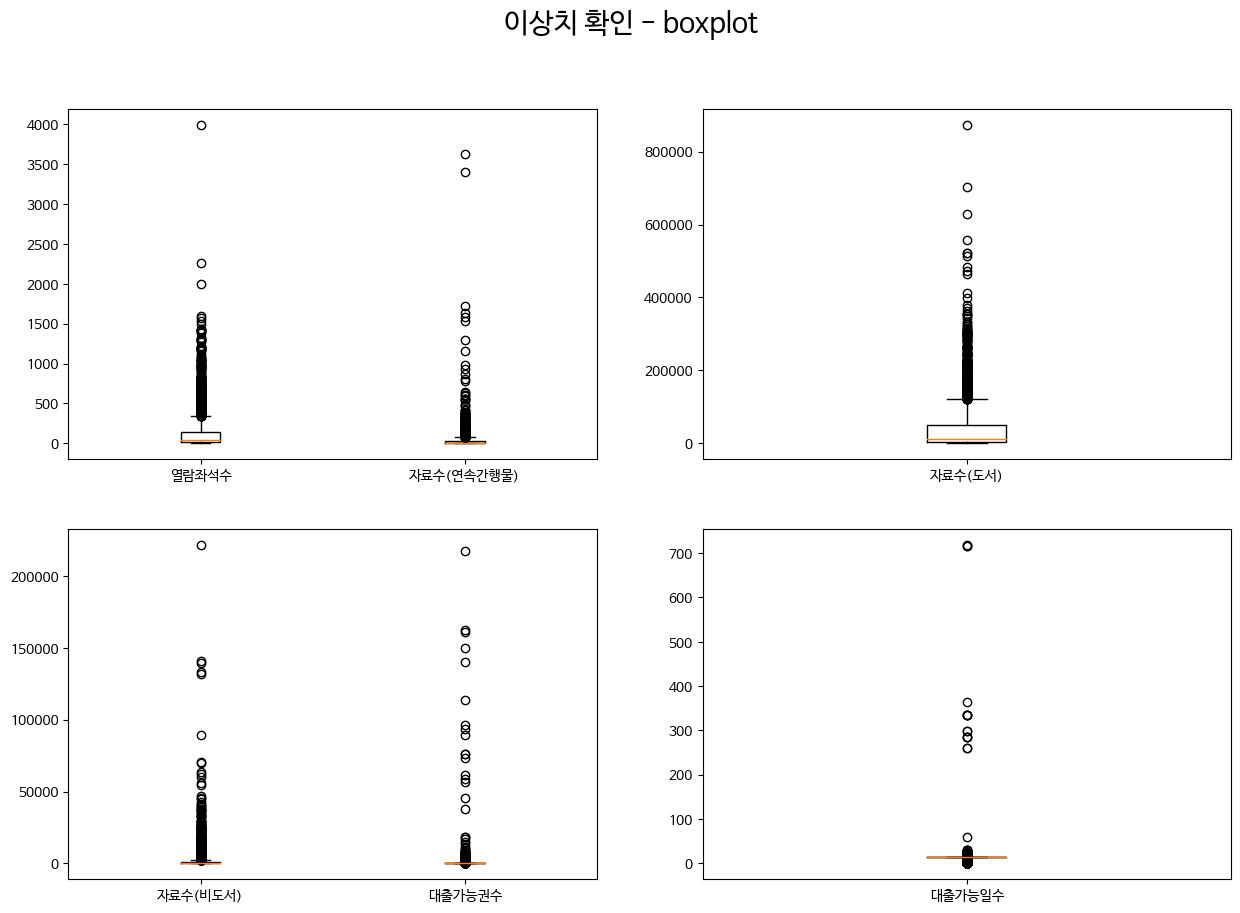

In [ ]:
#box plot으로 확인
#box plot 그리기 위하여 불러옴
import matplotlib.pyplot as plt


#박스플롯으로 이상치 확인
#연속형자료만 확인
#열람좌석수, 자료수(도서), 자료수(연속간행물),자료수(비도서), 대출가능권수, 대출가능일수


plt.figure(figsize=(15,10))

first_xlabel = ['열람좌석수', '자료수(연속간행물)']
plt.subplot(2, 2, 1)
plt.boxplot(pro_data.loc[:,first_xlabel])
plt.xticks([1,2], labels= first_xlabel)


second_xlabel = ['자료수(도서)']
plt.subplot(2, 2, 2)
plt.boxplot(pro_data.loc[:, second_xlabel])
plt.xticks([1], labels= second_xlabel)


third_xlabel = ['자료수(비도서)', '대출가능권수']
plt.subplot(2, 2, 3)
plt.boxplot(pro_data.loc[:, third_xlabel])
plt.xticks([1,2], labels= third_xlabel)


fourth_xlabel = ['대출가능일수']
plt.subplot(2, 2, 4)
plt.boxplot(pro_data.loc[:, fourth_xlabel].dropna())
plt.xticks([1], labels= fourth_xlabel)

plt.suptitle('이상치 확인 - boxplot', fontsize = 20)

plt.show()

In [ ]:
# 도서관 유형 확인
pro_data['도서관유형'].groupby(pro_data['도서관유형']).count()

도서관유형
공공도서관     1398
대학도서관        1
어린이도서관      32
작은도서관     2167
장애인도서관       2
전문도서관        3
학교도서관       26
Name: 도서관유형, dtype: int64

In [ ]:
# 도서관 유형별 요약 확인
#num_group_data = pro_data.loc[:,['도서관유형','열람좌석수', '자료수(도서)', '자료수(연속간행물)','자료수(비도서)', '대출가능권수', '대출가능일수']].groupby('도서관유형')

#num_group_data.describe()

AttributeError: ignored

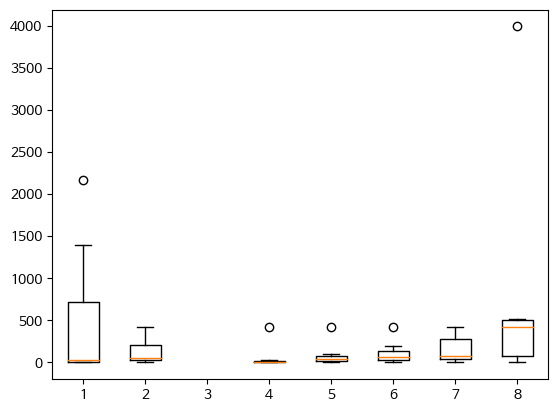

In [ ]:
# 도서관 유형별 열람좌석수 요약 확인
num_group_seat_data = pro_data.loc[:,['도서관유형', '열람좌석수']].groupby(pro_data['도서관유형'])
tmp1 = num_group_seat_data.describe()

plt.boxplot(tmp1)
plt.xlabel(tmp1.indexs) #인덱스를 xlabel로 지정할 수 없는지 찾아보기..
plt.show()

In [ ]:
# 도서관 유형별 요약 확인
num_group_book_data = pro_data.loc[:,['도서관유형', '자료수(도서)']].groupby('도서관유형')

num_group_book_data.describe()

자료수(도서)                                                              \
         count           mean           std       min        25%       50%   
도서관유형                                                                        
공공도서관   1398.0   89844.488555  82586.371358       0.0   38084.50   68215.0   
대학도서관      1.0  170997.000000           NaN  170997.0  170997.00  170997.0   
어린이도서관    32.0   58476.843750  40729.549567   11279.0   22222.50   42166.5   
작은도서관   2167.0    7593.887863   7151.425757       0.0    2833.00    5991.0   
장애인도서관     2.0    3196.000000      0.000000    3196.0    3196.00    3196.0   
전문도서관      3.0   56664.333333  44197.330195   11653.0   34996.50   58340.0   
학교도서관     26.0   12435.653846   5704.935323    5348.0    8329.75   11783.5   

                             
              75%       max  
도서관유형                        
공공도서관   113030.75  872312.0  
대학도서관   170997.00  170997.0  
어린이도서관  101127.25  134617.0  
작은도서관    10422.00  172783.0  
장애인도서관    3196.00    3196.0  
전문도서관    79170.00  100000.0  
학교도서관    15384.75   28525.0

In [ ]:
pro_data[pro_data['대출가능일수']>700][['도서관명', '대출가능일수']]

,도서관명,대출가능일수
125,영암도서관,717
179,삼호도서관,718
180,학산도서관,717


In [ ]:
pro_data[pro_data['자료수(도서)']>200000][['도서관명', '대출가능일수', '자료수(도서)']]

,도서관명,대출가능일수,부지면적,자료수(도서)
14,정관도서관,14,8000.0,209012
20,정약용도서관,14,21501.0,209359
46,김천시립도서관,15,18770.0,246726
54,중앙도서관,14,2030.0,246197
123,갈마도서관,14,1488.0,217011
...,...,...,...,...
3595,부평도서관,15,NaN,239133
3596,북구도서관,15,NaN,305670
3603,계양도서관,15,NaN,217273
3609,서구도서관,15,NaN,263047


In [ ]:
see_data = pro_data.loc[:,['도서관명', '위도','경도']]

## ====================================================

### 테스트

In [ ]:
dic = {"위도" : pro_data['위도'], "경도" : data1['경도']}

In [ ]:
location1 = pd.DataFrame(dic)

In [ ]:
location1

,위도,경도
0,37.658160,127.299532
1,37.176854,129.335484
2,37.829691,127.506433
3,37.683315,127.491015
4,37.739591,127.424230
...,...,...
3624,NaN,NaN
3625,NaN,NaN
3626,38.125564,128.205558
3627,37.955236,128.319014


In [ ]:
for i in location1:
    print(i)
    break

위도


In [ ]:
# 지도 시각화를 위해 라이브러리 불러옴
import folium

#folium.Map(location=[위도, 경도])
x=37.013983
y=127.203149
m = folium.Map(location=[x, y])

In [ ]:
folium.Marker([x, y]).add_to(m)
m